# Depression Analysis

In [1]:
import os, sys
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data import make_dataset
from visualizations import visualize
from features.make_features import get_avg_daily_sleep_period

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
control_1 = pd.read_csv('../data/raw/control/control_1.csv')
condition_1 = pd.read_csv('../data/raw/condition/condition_1.csv')
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [4]:
control_1.head()

,timestamp,date,activity
0,2003-03-18 15:00:00,2003-03-18,60
1,2003-03-18 15:01:00,2003-03-18,0
2,2003-03-18 15:02:00,2003-03-18,264
3,2003-03-18 15:03:00,2003-03-18,662
4,2003-03-18 15:04:00,2003-03-18,293


In [5]:
condition_1.head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [6]:
condition_1.describe()

,activity
count,23244.000000
mean,146.948030
std,294.592424
min,0.000000
25%,0.000000
50%,9.000000
75%,172.000000
max,3526.000000


In [7]:
control_1.describe()

,activity
count,51611.000000
mean,98.545078
std,289.655317
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,6117.000000


## Exploratory Data Analysis

### Activity Distribution

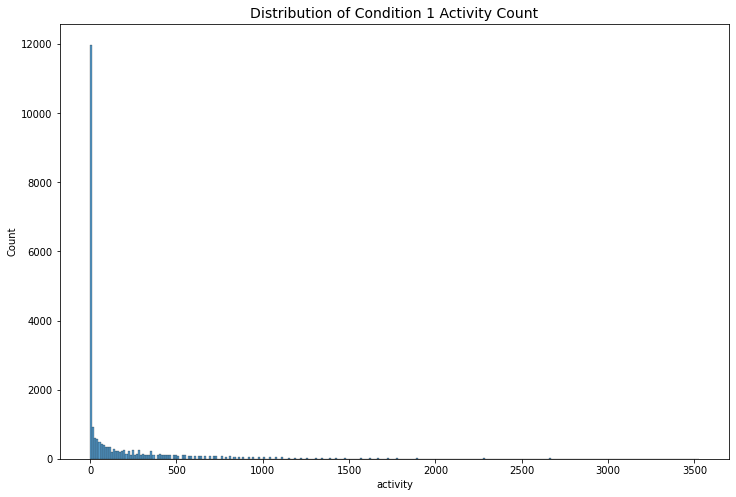

In [8]:
visualize.plot_histogram(x='activity', data=condition_1, title='Distribution of Condition 1 Activity Count', filename='../reports/figures/condition_1_activity_distr.jpeg')

In [9]:
condition_1['activity'].skew()

3.8823677090908344

In [10]:
control_1['activity'].skew()

5.039169993104665

In [11]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1)
condition_1['log_activity'].skew()

0.2771381485812395

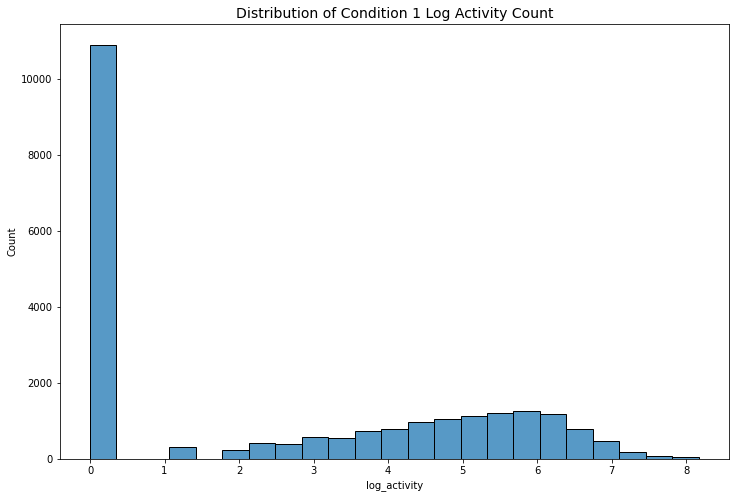

In [12]:
visualize.plot_histogram(x='log_activity', data=condition_1, title='Distribution of Condition 1 Log Activity Count',  filename='../reports/figures/condition_1_log_activity_distr.jpeg')

In [13]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

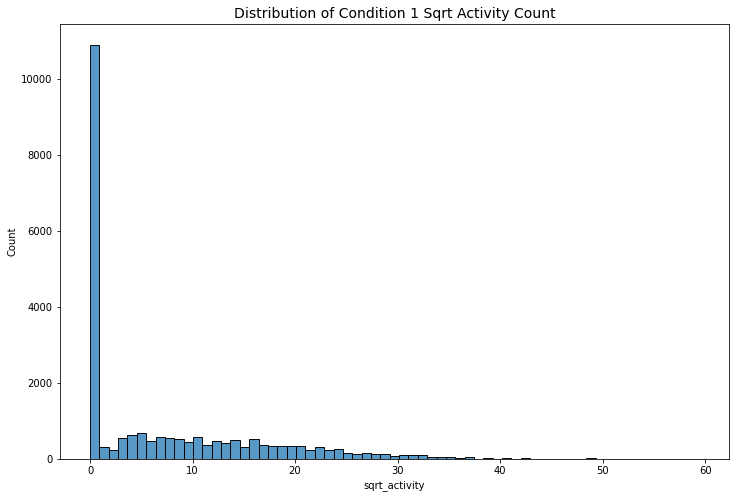

In [14]:
visualize.plot_histogram(x='sqrt_activity', data=condition_1, title='Distribution of Condition 1 Sqrt Activity Count')

In [15]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

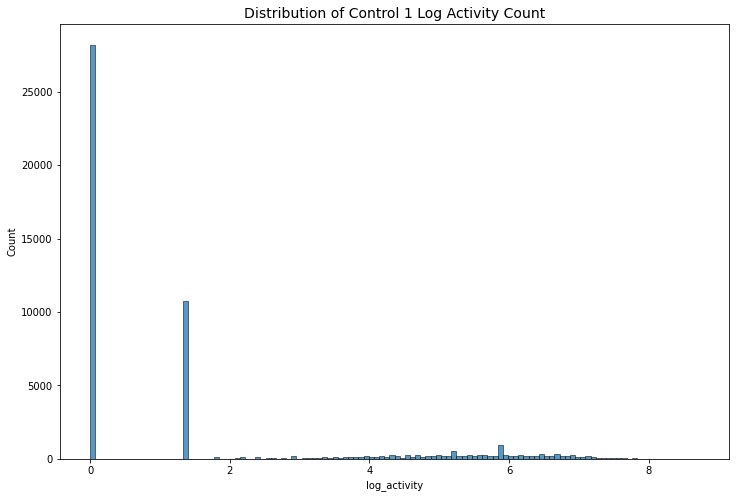

In [16]:
visualize.plot_histogram(x='log_activity', data=control_1, title='Distribution of Control 1 Log Activity Count',  filename='../reports/figures/control_1_log_activity_distr.jpeg')

In [17]:
control_1['sqrt_activity'] = np.sqrt(control_1['activity'])
control_1['sqrt_activity'].skew()

2.4024647298843784

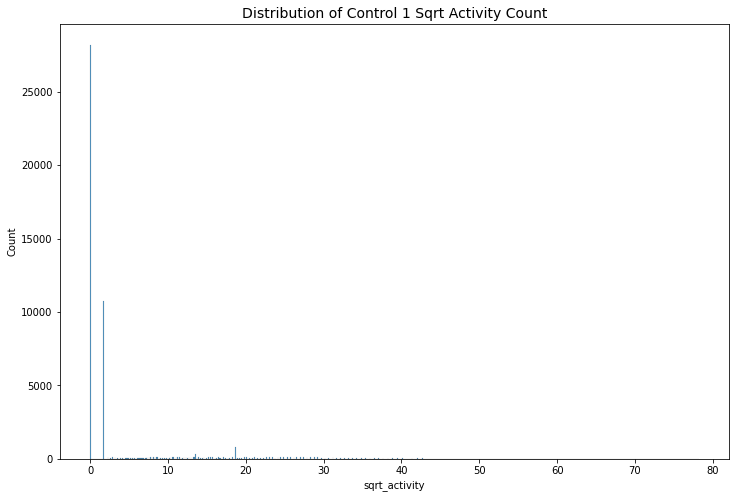

In [18]:
visualize.plot_histogram(x='sqrt_activity', data=control_1, title='Distribution of Control 1 Sqrt Activity Count')

## Time Series Analysis

In [19]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df

In [20]:
combine_df = combine_data('../data/raw/condition/')

In [21]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [22]:
combine_df = combine_data('../data/raw/control/')

In [23]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

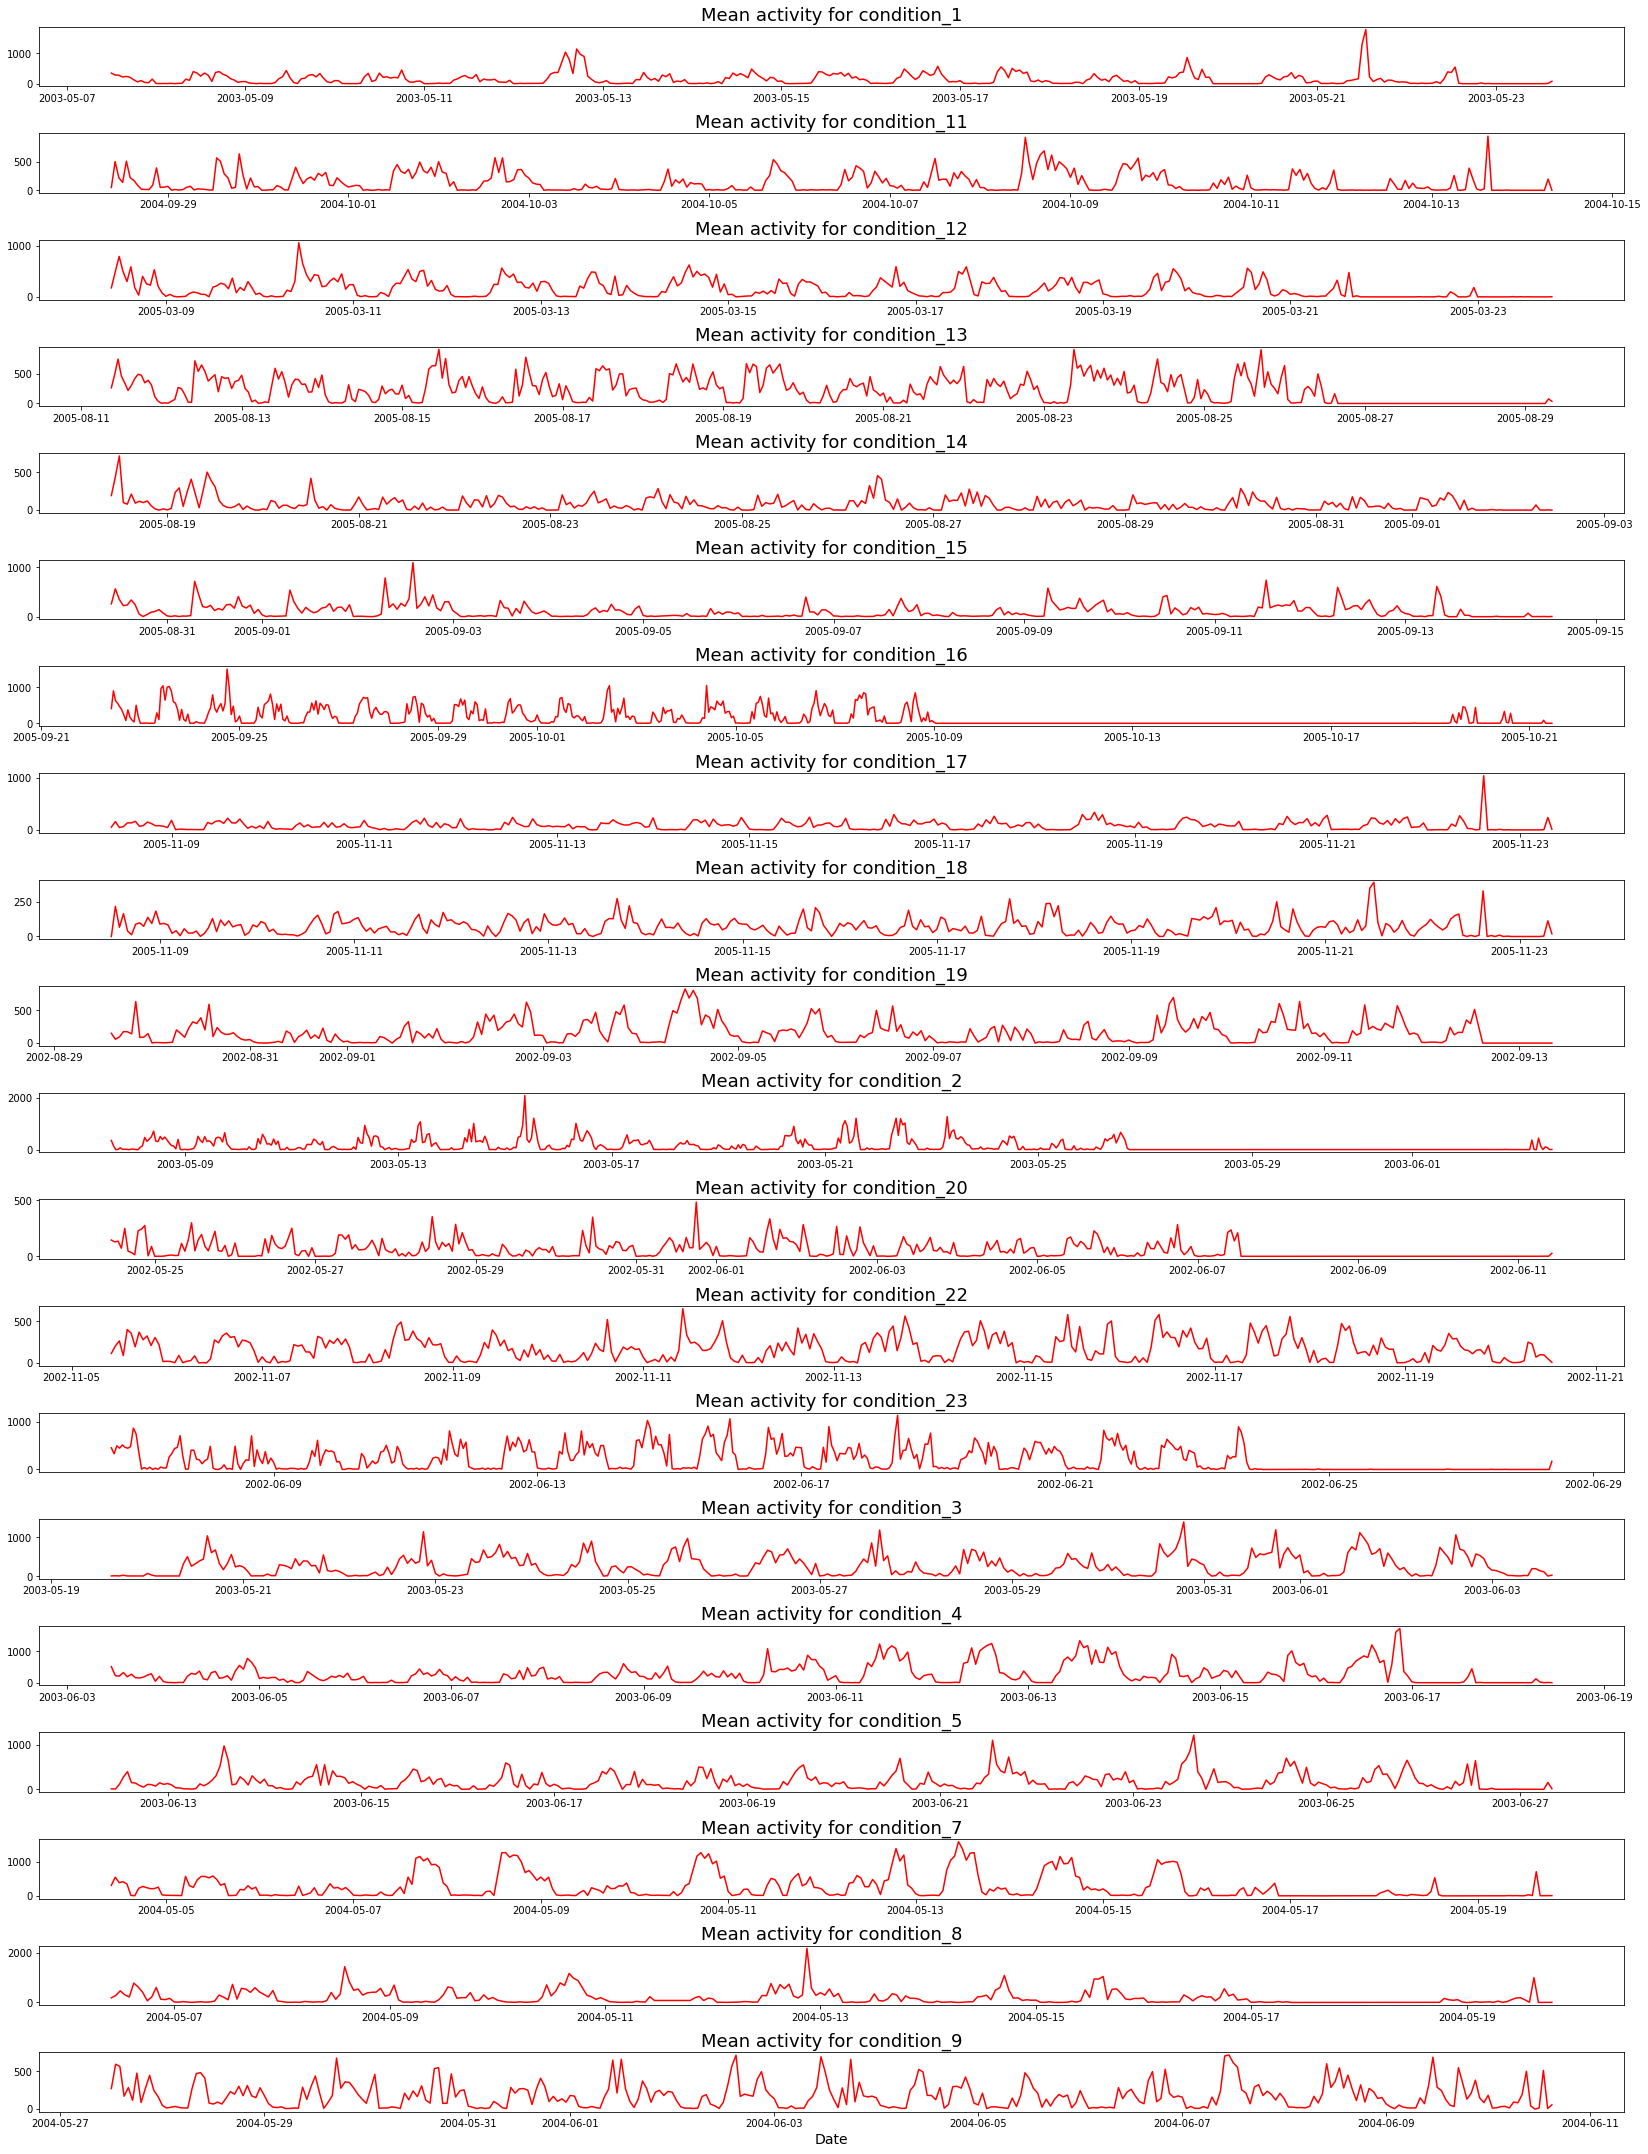

In [24]:
fig, axes = plt.subplots(len(conditions), 1, figsize=(23, 30))
for i in range(len(conditions)):
    condition = conditions[i]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

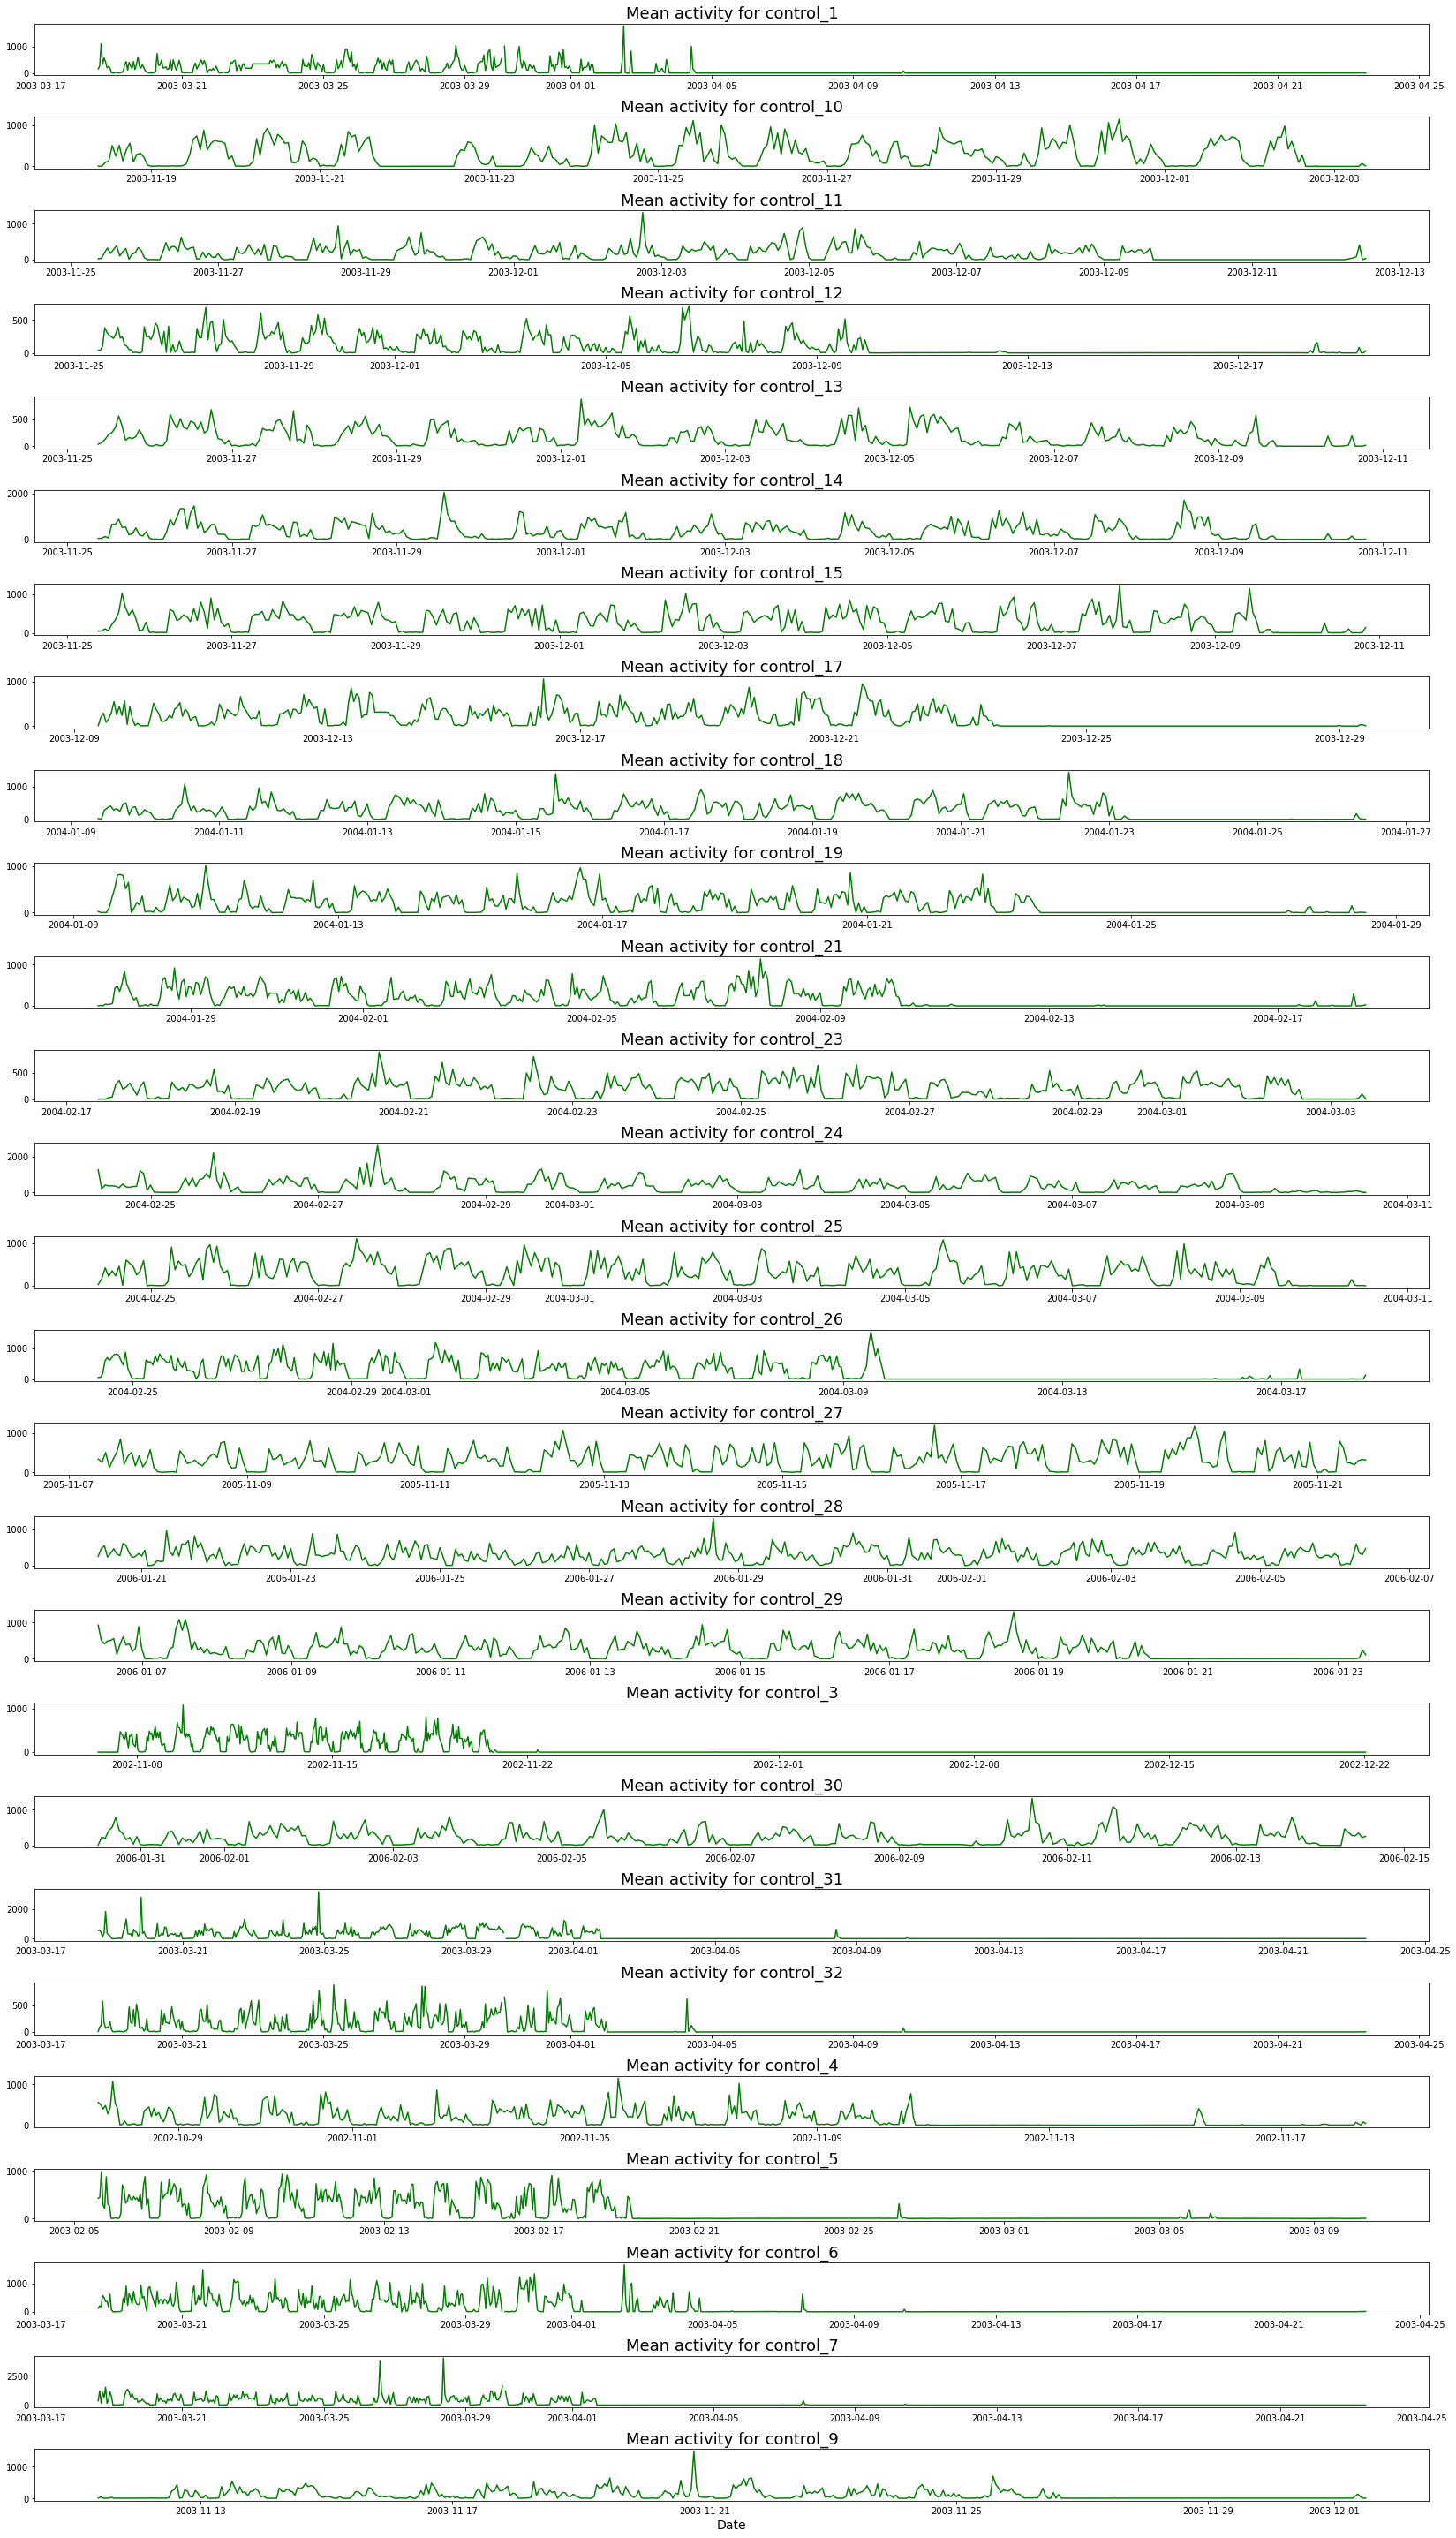

In [25]:
fig, axes = plt.subplots(len(controls), 1, figsize=(23, 40))
cnt = 0
for i in range(len(controls)):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [26]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

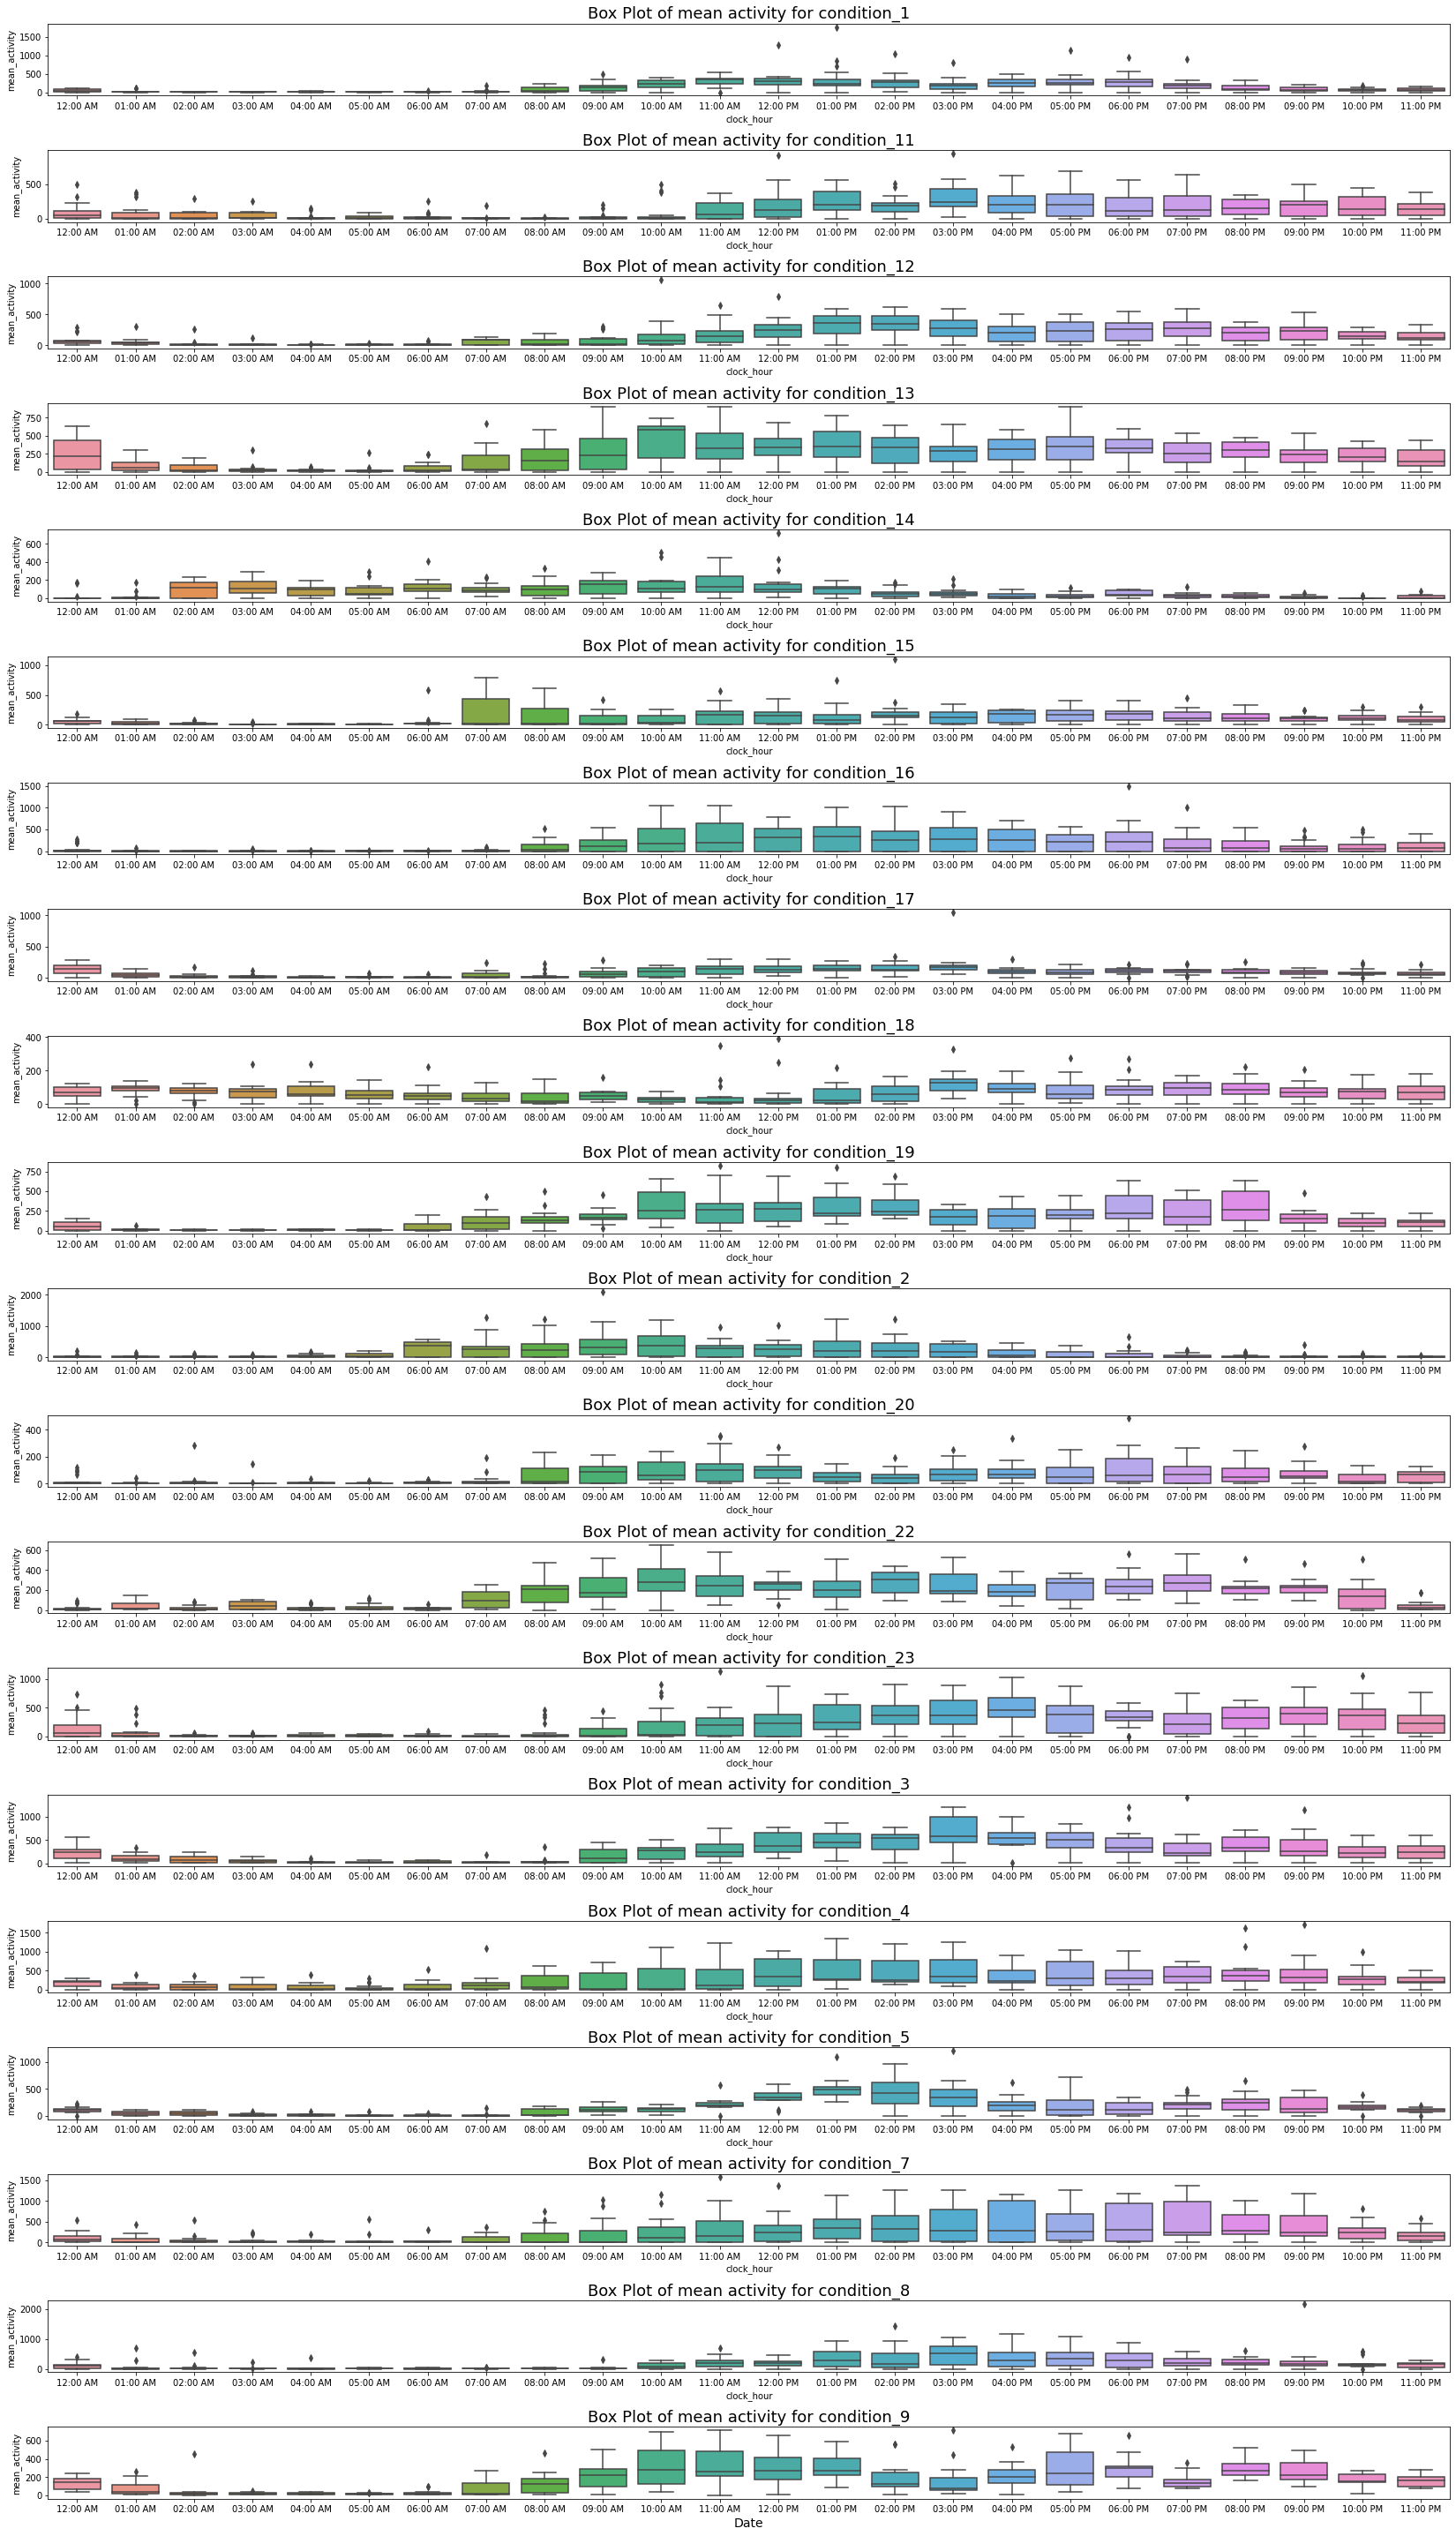

In [27]:
# Draw Plot
fig, axes = plt.subplots(len(conditions), 1, figsize=(23, 40))

for i in range(len(conditions)):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Box Plot mean activity of condition group.jpg', dpi=100)
plt.show()

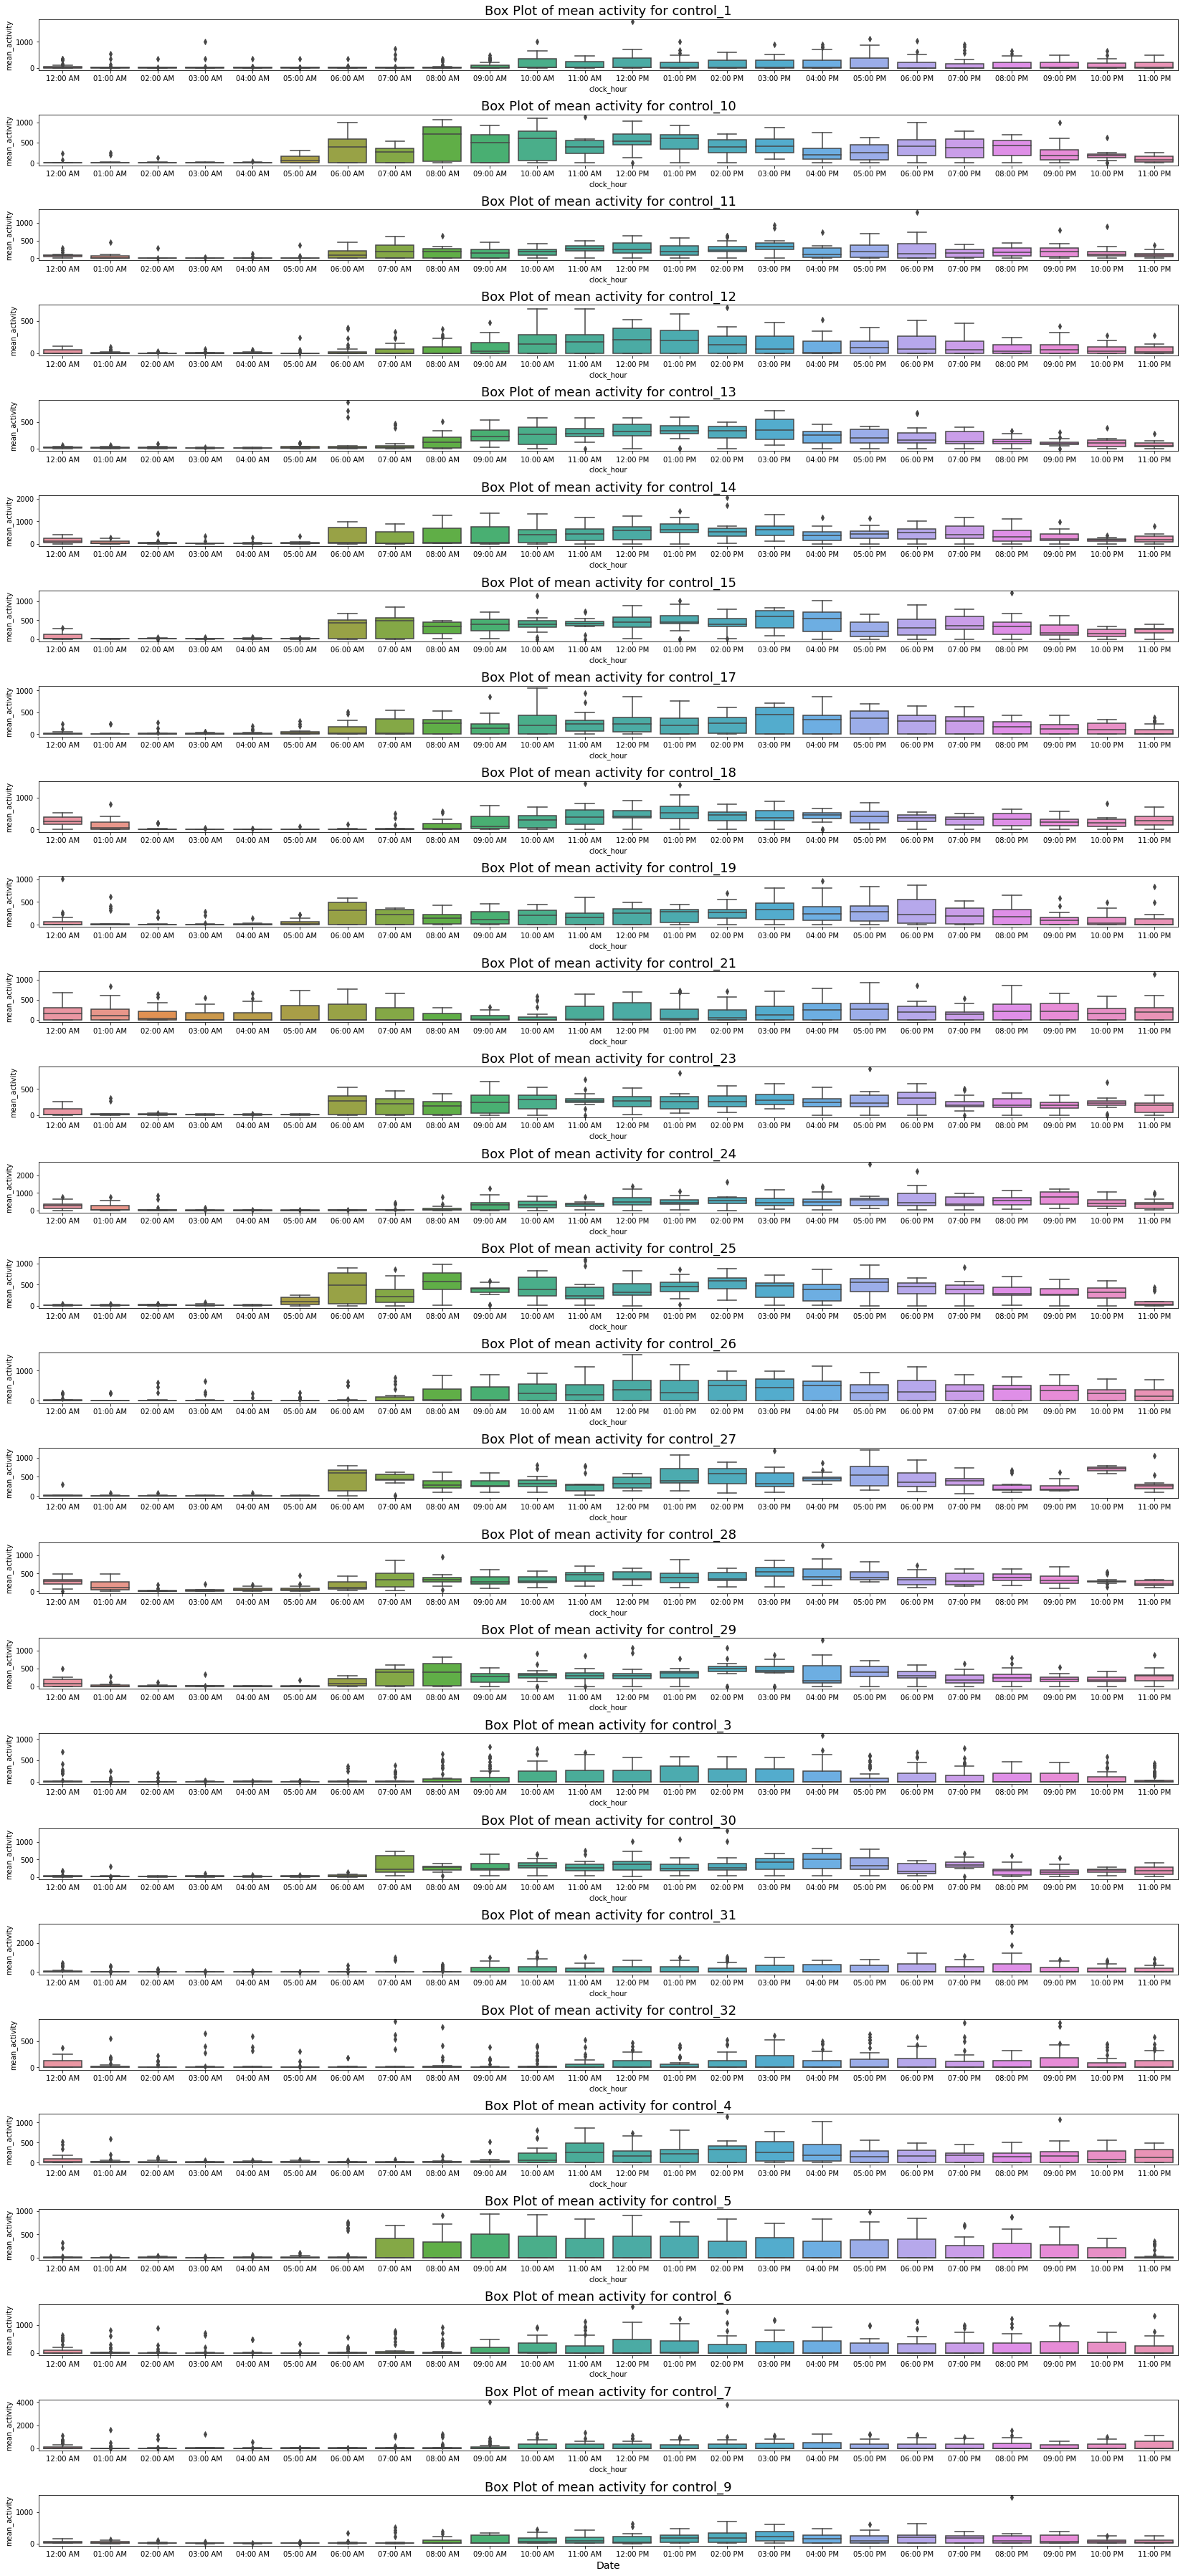

In [28]:
# Draw Plot
fig, axes = plt.subplots(len(controls), 1, figsize=(23, 50))

for i in range(len(controls)):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Box Plot mean activity of control group.jpg', dpi=100)
plt.show()

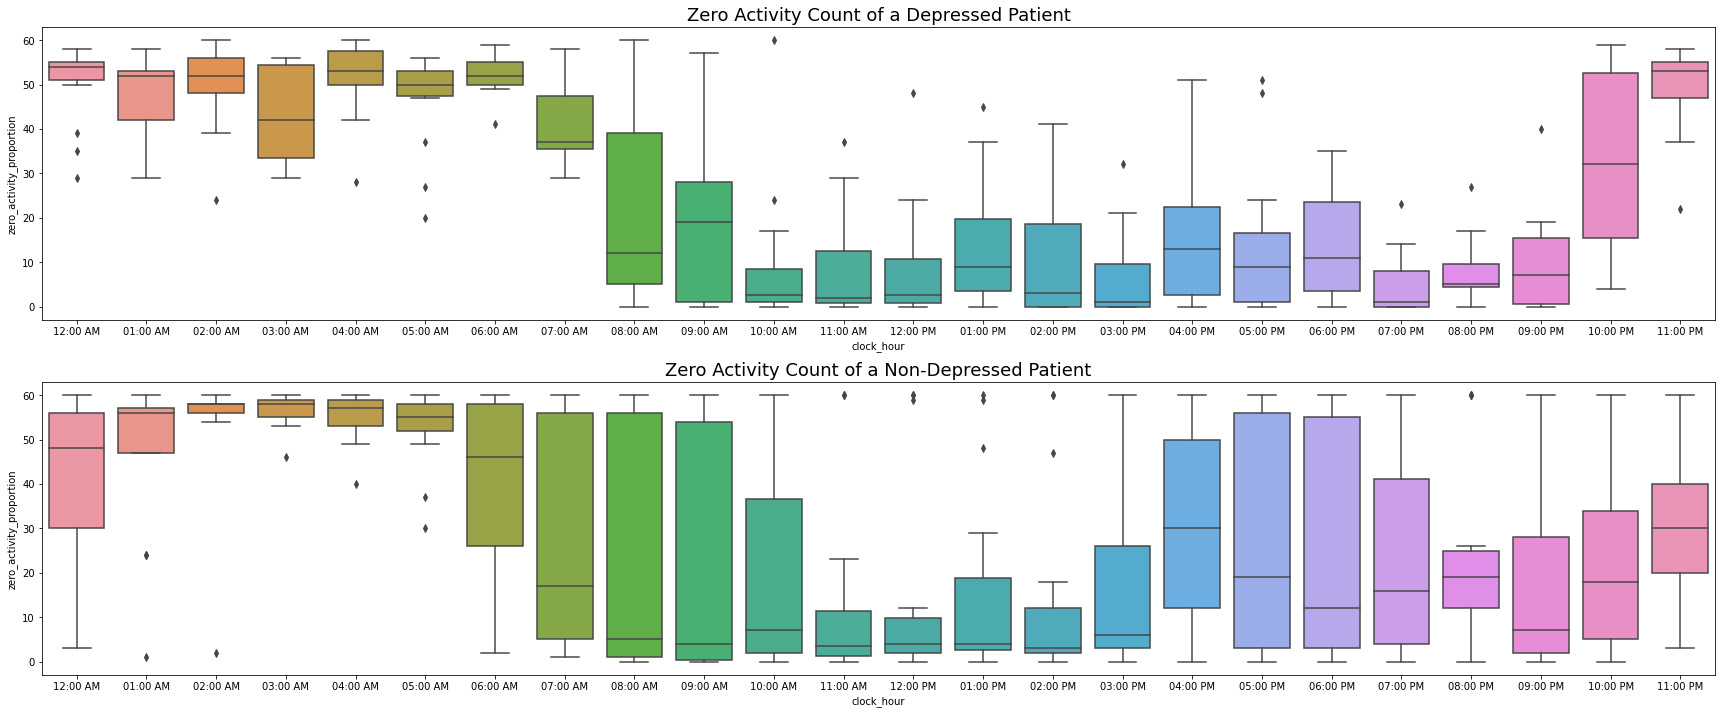

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
fig.savefig('Box Plot mean zero activity comparison.jpg', dpi=100)
plt.show()

Let's correct the activity data since we have multiple hours (greater than normal that contains zero activity)

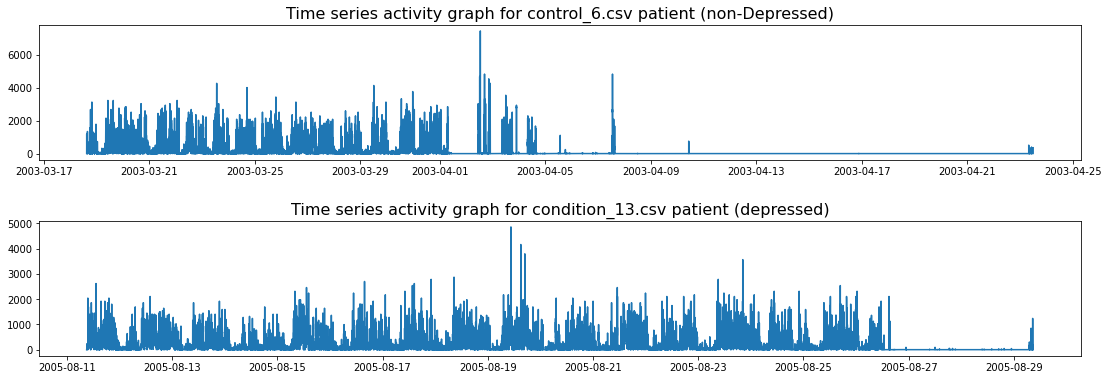

In [30]:
visualize.view_random_activity()

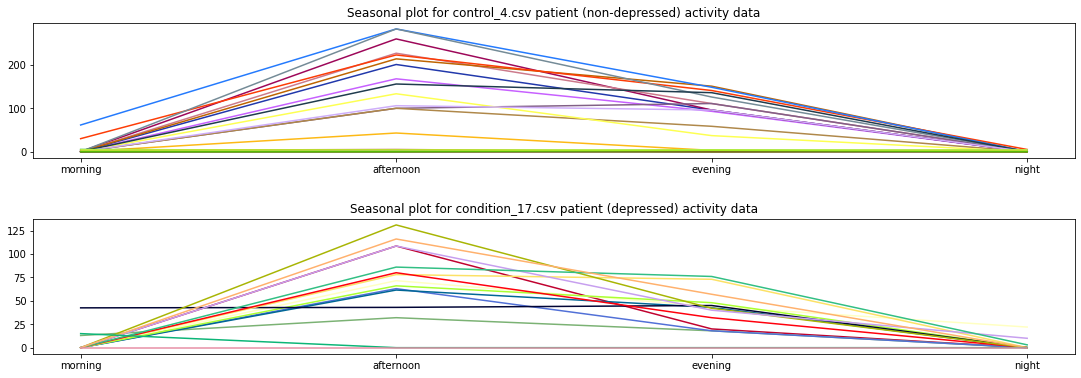

In [31]:
fig = visualize.view_seasonality()
fig.savefig('../reports/figures/seasonal_plot.jpg', dpi=80)

The seasonality graph does not show us a clear difference between depressed and non-depressed patients

## Sleep Parameters

In [32]:
# Sleep scoring
raw_path = '../data/raw'
interim_path = '../data/interim'

#make_dataset.sleep_score_dataset(raw_path=raw_path, interim_path=interim_path)

In [33]:
# Mark Sleep Intervals 
make_dataset.sleep_interval_dataset(raw_path=interim_path, interim_path=interim_path)

In [34]:
# Sleep period for a depressed and non-depressed patient
control_2 = get_avg_daily_sleep_period(pd.read_csv(f'{interim_path}/control/control_2.csv', parse_dates=['timestamp']))
condition_9 = get_avg_daily_sleep_period(pd.read_csv(f'{interim_path}/condition/condition_9.csv', parse_dates=['timestamp']))

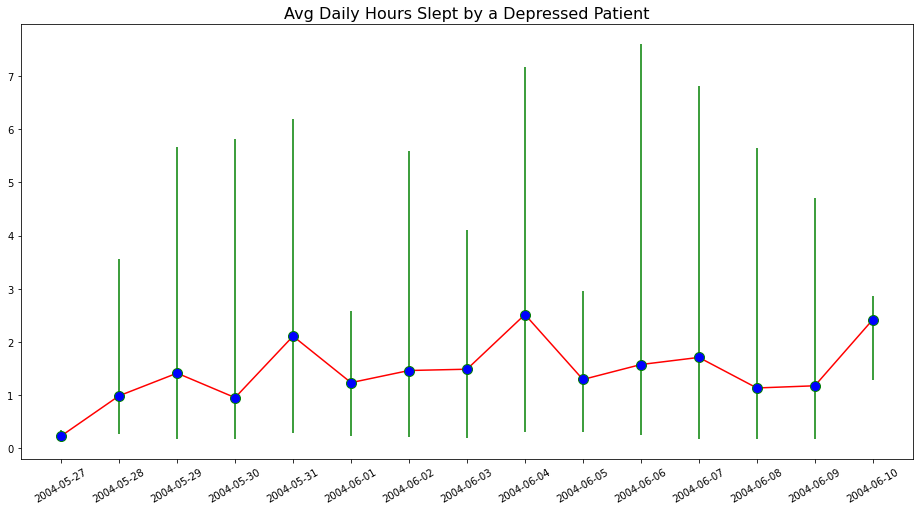

In [35]:
# plot data with error bars
visualize.plot_sleep_period(condition_9, error_bar=True,  title='Avg Daily Hours Slept by a Depressed Patient', filename='../reports/figures/cond_sleep_period.jpeg')

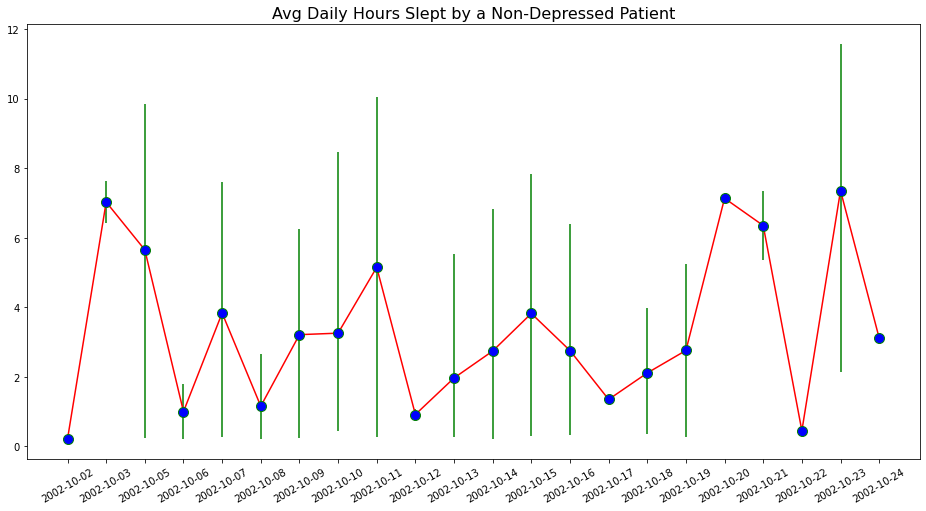

In [36]:
# plot data with error bars
visualize.plot_sleep_period(control_2, error_bar=True,  title='Avg Daily Hours Slept by a Non-Depressed Patient', filename='../reports/figures/cont_sleep_period.jpeg')

## A/B Testing

**H0:** There is no significant difference between the mean activity of control patients and condition patients

**H1:** There is a significant difference between the mean activity of control patients and condition patients